In [1]:
# Useful additional packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from IPython.display import clear_output

from sympy import Matrix
from IPython.display import display, Math, Latex
clear_output()

print('Succesful import')

Succesful import


In [2]:
def addkeys(dictionary): #Housekeeping function, replaces all missing values with 0
    expectedkeys = ['00','01','10','11']
    for key in expectedkeys:
        if key in dictionary:
            pass
        else:
            dictionary[key] = 0
    return dictionary

In [3]:
a = addkeys({'01':100,'00':1000})
print(a)

{'01': 100, '00': 1000, '10': 0, '11': 0}


## Interpretation of Model
<p>The first qubit (indexed by 0) refers to the polarisation DOF and the second qubit (index 1) refers to the parity DOF. We will take the $|1\rangle$ state of polarity to mean pure V-polarisation and $|0\rangle$ state to mean pure H-polarisation. Similarly, we take the $|0\rangle$ and $|1\rangle$ states of the parity qubit to mean purely even and purely odd mode, respectively.</p>
<table>
    <tr><td>Parity-polarisation state</td><td>Qubit configuration</td></tr>
    <tr><td>He</td><td>00</td></tr>
    <tr><td>Ho</td><td>01</td></tr>
    <tr><td>Te</td><td>10</td></tr>
    <tr><td>To</td><td>11</td></tr>
</table>
<p>Further, we will always use any ancilla qubits we need, to replicate the probabilistic devices (like random rotator or probabilistic PS-SLM) to be the initial qubits, the second last qubit will represent polarisation, and the last qubit represents parity.</p>

In [4]:
def SLM(phi,qc,ancilla_used = 0):
    qc.rx(-phi,ancilla_used+1)
    return
#For HWP, by observing the 2x2 matrix, we see that the operator looks like Ry(theta)*sigma_Z 
def HWP(theta,qc,ancilla_used = 0):
    qc.z(ancilla_used)
    qc.ry(theta,ancilla_used)
    return

#for PS-SLM, we want the H-polarisation to induce an SLM action, but not V. So, if polarisation qubit is 0 (H), we want the
#controlled gate to fire. So we first invert (NOT or X gate) the control bit, use a usual controlled gate, then invert it 
#again.
def PSSLM(phi,qc,ancilla_used=0):
    qc.x(ancilla_used)
    qc.crx(-phi,ancilla_used,ancilla_used+1) #angle,control,target
    qc.x(ancilla_used)
    return

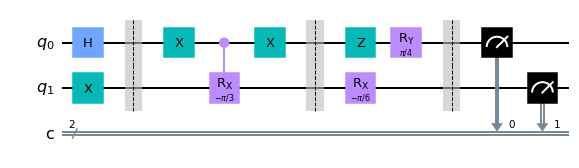

In [3]:
#Quantum Circuit Diagram
qcA = QuantumCircuit(2,2)
qcA.h(0)
qcA.x(1)
qcA.barrier() #initialisation complete, 45 degre linearly polarised even mode
PSSLM(pi/3,qcA) #no ancilla
qcA.barrier() #beam is coupled, now on to analysis stage
HWP(pi/4,qcA)
SLM(pi/6,qcA)
qcA.barrier()#Analysis stage complete. Now, measurement stage
qcA.measure(0,0)
qcA.measure(1,1)
qcA.draw()

In [47]:
def CA(theta_a,phi_a,phi):
    N = 10000 #Number of shots
    qcA=QuantumCircuit(2,2)
    qcA.h(0)
    qcA.x(1)
    qcA.barrier() #initialisation complete, 45 degre linearly polarised even mode
    PSSLM(phi,qcA) #no ancilla
    qcA.barrier() #beam is coupled, now on to analysis stage
    HWP(theta_a,qcA)
    SLM(phi_a,qcA)
    qcA.barrier()#Analysis stage complete. Now, measurement stage
    qcA.measure(0,0)
    qcA.measure(1,1)
    backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
    result = execute(qcA, backend, shots = N).result() # we run the simulation
    counts = addkeys(result.get_counts()) # we get the counts and do the housekeeping
    corr = (counts['00']+counts['11']-counts['10']-counts['01'])/N
    #return corr,counts
    return corr

In [12]:
def RandomRot(qc,ancillary_used=0):
    theta = np.random.uniform(low=0,high=2*pi)
    qc.z(ancillary_used)
    qc.ry(theta,ancillary_used)
    return

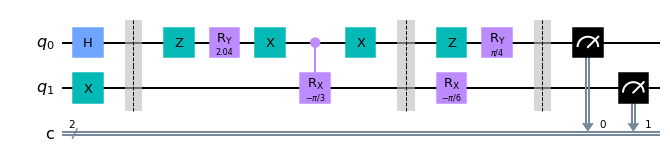

In [13]:
qcB = QuantumCircuit(2,2)
qcB.h(0)
qcB.x(1)
qcB.barrier() #have generated input beam. Now on to the synthesis stage.
RandomRot(qcB)
PSSLM(pi/3,qcB)
qcB.barrier() #Now, analysis stage
HWP(pi/4,qcB)
SLM(pi/6,qcB)
qcB.barrier()#Analysis stage complete. Now, measurement stage
qcB.measure(0,0)
qcB.measure(1,1)
qcB.draw()

In [31]:
def CB(theta_a,phi_a,phi):
    N = 2000
    count00 = 0
    count01 = 0
    count10 = 0
    count11 = 0
    for i in range(N):
        qcB = QuantumCircuit(2,2)
        qcB.h(0)
        qcB.x(1)
        qcB.barrier() #have generated input beam. Now on to the synthesis stage.
        RandomRot(qcB)
        PSSLM(phi,qcB)
        qcB.barrier() #Now, analysis stage
        HWP(theta_a,qcB)
        SLM(phi_a,qcB)
        qcB.barrier()#Analysis stage complete. Now, measurement stage
        qcB.measure(0,0)
        qcB.measure(1,1)
        backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
        result = execute(qcB, backend, shots = 1).result() # we run the simulation
        counts = addkeys(result.get_counts()) # we get the counts and do the housekeeping
        count00 += counts['00']
        count01 += counts['01']
        count10 += counts['10']
        count11 += counts['11']
    #print(count00,count01,count10,count11)
    corr = (count00+count11-count01-count10)/N
    return corr

In [33]:
CB(0,0,0)

-0.01

In [ ]:
#This cell does not work, numpy arrays are a pain for qiskit
phi_fixed = pi/2
points = 50
ta_range = np.linspace(0,2*pi,points)
pa_range = np.linspace(0,2*pi,points)
X,Y = np.meshgrid(ta_range, pa_range)
for i in len
    Z = CA(ta_range,pa_range,phi_fixed)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
plt.xlim(0,2*np.pi)
plt.ylim(0,2*np.pi)
ax.axis('equal')